In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)

import pandas as pd
import numpy as np
import tflscripts
from tflscripts import boxplot_by, scatter_plot_by, heatmap_by
import json
import pickle

configuration = tflscripts.read_configuration()
df = pd.read_pickle('results.p')

In [24]:
without_transfer = df.loc[df.type_of_transfer == 'No transfer']
df_replicas = df.loc[df.source_room == df.target_room]
# df_replicas = df_replicas.loc[df_replicas.source_placement == df_replicas.target_placement]
# df_replicas = df_replicas.loc[df_replicas.source_device_type == df_replicas.target_device_type]
df_replicas = df_replicas.loc[df_replicas.type_of_transfer == 'Same device type in same place']
df_replicas = df_replicas.loc[df_replicas.source_device_type == 'Mite']

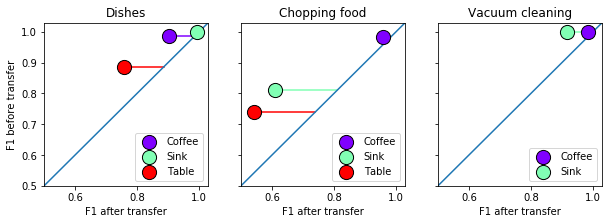

In [26]:
plt.rcParams["figure.figsize"] = (10, 3)
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)

x_value_column='f1'
y_value_column='f1_wt'

df_plot = df_replicas.loc[df_replicas.label.isin([
    'Alarm', 'Blender running', 'Vacuum cleaning', 'Coffee',
    'Chopping food', 'Dishes', 'Microwave',  'Cupboard door closed'
])]
df_plot = df_plot.loc[df_plot.type_of_transfer != 'No transfer']
df_plot = df_plot.loc[df_plot.classifier == 'SVM']
df_plot = df_plot.loc[df_plot.features_name == 'All']
# df_plot = df_plot.loc[df_plot.source_device == df_plot.target_device]
df_plot = df_plot.groupby(['classifier', 'features_name', 'label', 'source_placement', 'target_placement'])['f1', 'f1_wt'].mean()
df_plot = df_plot.reset_index()

def create_scatter(label, ax, show_y_label=True, use_colors={}):
    subdf_plot = df_plot.loc[df_plot.label == label]
    use_colors, use_markers, _df = scatter_plot_by('source_placement',
                    x_value_column=x_value_column, y_value_column=y_value_column,
                    label=None,
                    classifier='SVM',
                    features='All',
                    ylabel='F1 before transfer' if show_y_label else '',
                    xlabel='F1 after transfer',
                    title=label,
                    size=200,
                    common_limits=True,
                    min_val=0.5,
                    max_val=1.03,
                    ax=ax,
                    df_plot=subdf_plot)
    plt.legend(loc=4)

    for _, row in _df.iterrows():
        plt.plot([row['f1'], row['f1_wt']], [row['f1_wt'], row['f1_wt']], color=use_colors[row['source_placement']], zorder=-100)

create_scatter('Vacuum cleaning', axes[2], False)
create_scatter('Dishes', axes[0], True)
create_scatter('Chopping food', axes[1], False)

In [27]:
y_value_column = 'recall_wt'
x_value_column = 'accuracy_change'
label='Alarm'
features='All'

plot_by('iterations', x_value_column=x_value_column, y_value_column=y_value_column, common_limits=False, label=label, features=features)
plot_by('source_dataset', x_value_column=x_value_column, y_value_column=y_value_column, common_limits=False, label=label, features=features)
plot_by('target_dataset', x_value_column=x_value_column, y_value_column=y_value_column, common_limits=False, label=label, features=features)
plot_by('source_placement', x_value_column=x_value_column, y_value_column=y_value_column, common_limits=False, label=label, features=features)
plot_by('source_device', x_value_column=x_value_column, y_value_column=y_value_column, common_limits=False, label=label, features=features)
plot_by('target_device', x_value_column=x_value_column, y_value_column=y_value_column, common_limits=False, label=label, features=features)
plot_by('devices', x_value_column=x_value_column, y_value_column=y_value_column, common_limits=False, label=label, features=features)
plot_by('replica', x_value_column=x_value_column, y_value_column=y_value_column, common_limits=False, label=label, features=features)
plot_by('samples_r', x_value_column=x_value_column, y_value_column='samples', common_limits=False, label=label, features=features)

NameError: name 'plot_by' is not defined

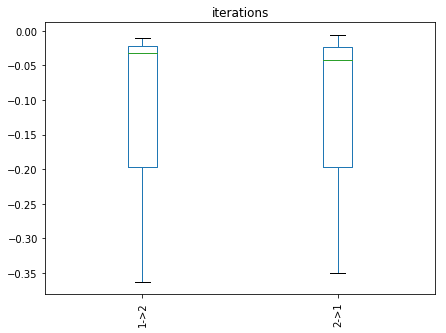

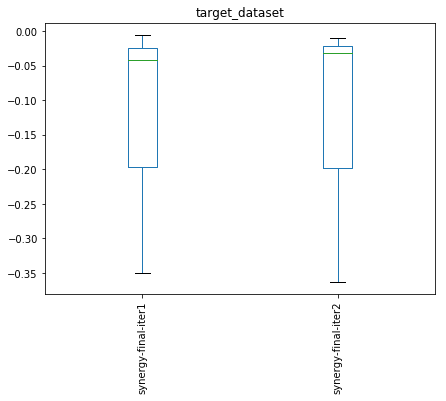

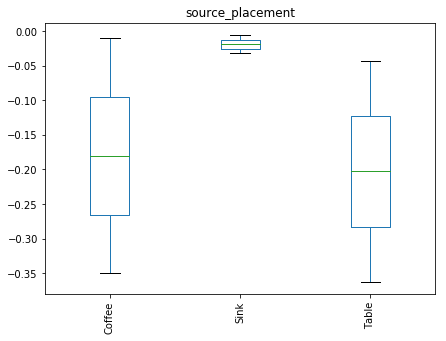

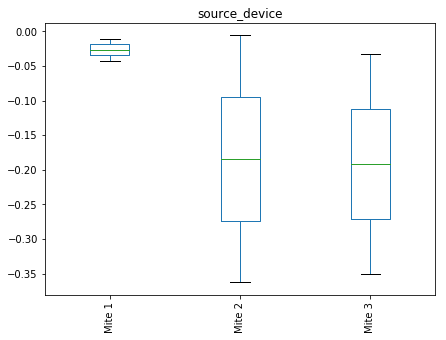

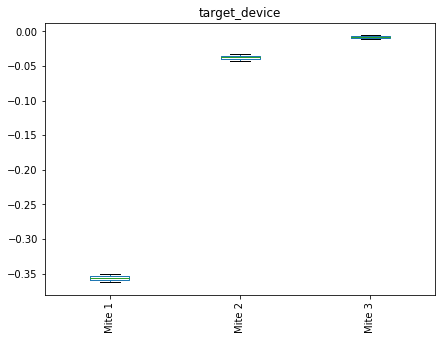

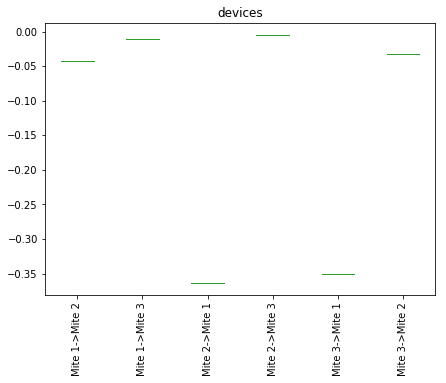

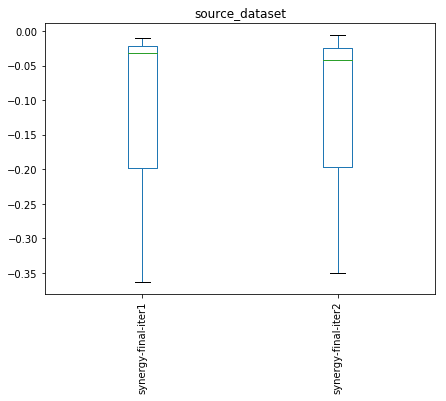

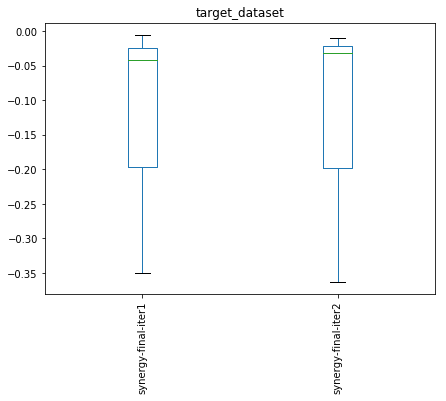

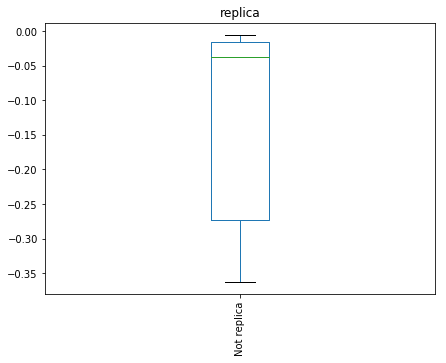

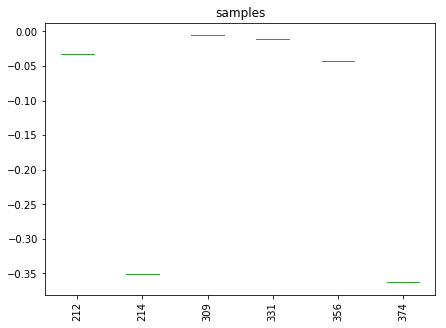

In [31]:
plt.rcParams["figure.figsize"] = (7, 5)

features = 'All'
label = 'Microwave'
value_column = 'recall_change'

boxplot_by('iterations', value_column=value_column, label=label, features=features)
boxplot_by('target_dataset', value_column=value_column, label=label, features=features)
boxplot_by('source_placement', value_column=value_column, label=label, features=features)
boxplot_by('source_device', value_column=value_column, label=label, features=features)
boxplot_by('target_device', value_column=value_column, label=label, features=features)
boxplot_by('devices', value_column=value_column, label=label, features=features)
boxplot_by('source_dataset', value_column=value_column, label=label, features=features)
boxplot_by('target_dataset', value_column=value_column, label=label, features=features)
boxplot_by('replica', value_column=value_column, label=label, features=features)
boxplot_by('samples', value_column=value_column, label=label, features=features)

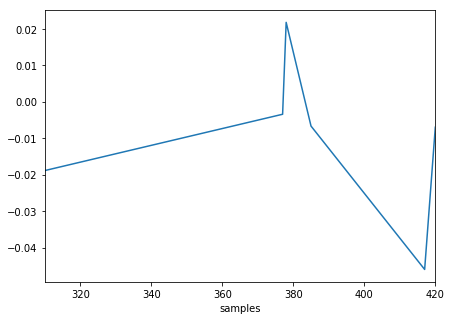

In [32]:
df_plot = df_replicas
df_plot = df_plot.loc[df_plot.label == 'Dishes']
df_plot = df_plot.loc[df_plot.features_name == 'Microphone']
df_plot = df_plot.loc[df_plot.classifier == 'SVM']
df_plot = df_plot[['samples', 'accuracy_change']]
df_plot.groupby(['samples'])['accuracy_change'].mean().plot()

0.98


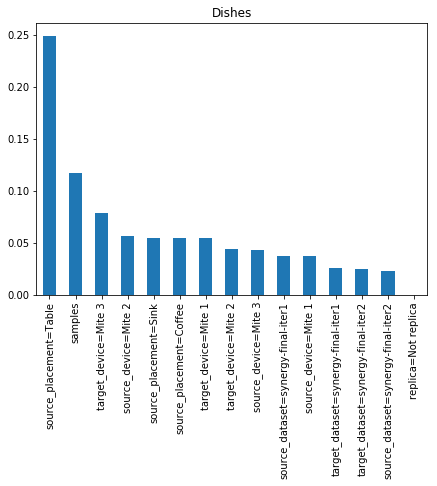

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score

label = 'Dishes'
features = 'All'
value_column = 'recall_change'

df_plot = df_replicas
df_plot = df_plot.loc[df_plot.label == label]
df_plot = df_plot.loc[df_plot.features_name == features]
df_plot = df_plot.loc[df_plot.classifier == 'LogisticRegression']
df_plot['y'] = np.round(df_plot[value_column] * 10)
X_columns = [
    'source_dataset', 'target_dataset',
    'source_device', 'target_device',
    'source_placement',
#     'accuracy_wt',
#     'recall_wt', 'specificity_wt',
    'replica',
    'samples'
]
X = df_plot[X_columns]
vect = DictVectorizer()

X = [dict(r.iteritems()) for _, r in X.iterrows()]
X = vect.fit_transform(X)
X = pd.DataFrame(X.toarray())
X.columns = vect.feature_names_

all_importances = []
accuracies = []

for i in range(50):
    rf = RandomForestClassifier()
    rf.fit(X.values, df_plot['y'].values)
    importances = pd.Series(rf.feature_importances_)
    all_importances.append(importances)
    accuracies.append(accuracy_score(df_plot['y'].values, rf.predict(X.values)))

importances = pd.DataFrame(all_importances).mean()
importances.index = X.columns
importances = importances.sort_values(ascending=False)
importances.plot.bar()
plt.title(label)
print(np.mean(accuracies))

In [34]:
df_replicas.source_device_name.unique()

array(['Mite 1 Table', 'Mite 4 Coffee', 'Mite 2 Sink', 'Mite 3 Coffee',
       'Mite 4 Sink', 'Mite 2 Coffee', 'Mite 1 Coffee', 'Mite 3 Sink',
       'Mite 2 Table'], dtype=object)

0.983333333333


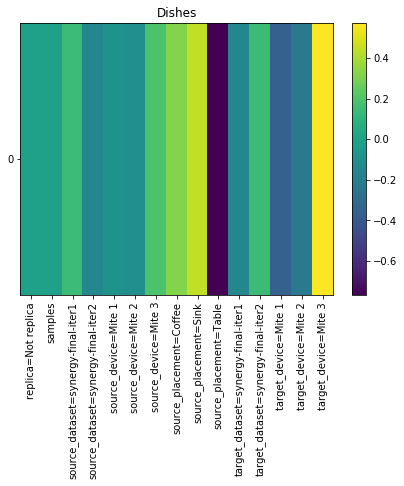

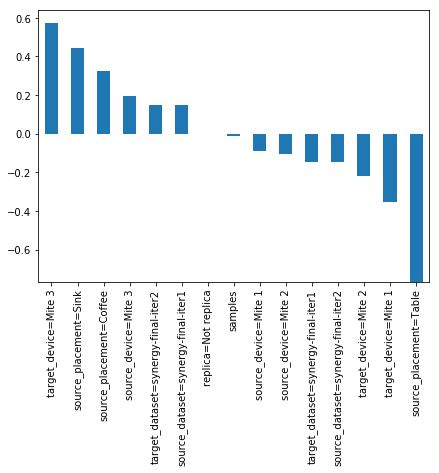

In [35]:
from sklearn.svm import SVC

all_coefficients = None
num_coefficients = 0
for i in range(10):
    clf = SVC(kernel='linear')
    clf.fit(X.values, df_plot['y'].values)
    if all_coefficients is None:
        all_coefficients = clf.coef_.copy()
    else:
        all_coefficients += clf.coef_.copy()
    num_coefficients += 1
    accuracies.append(accuracy_score(df_plot['y'].values, clf.predict(X.values)))

all_coefficients = all_coefficients / num_coefficients

weights = pd.DataFrame(all_coefficients)
weights.columns = X.columns
# weights.index = np.sort(df_plot['y'].unique())
plt.pcolor(weights)
plt.yticks(np.arange(0.5, len(weights.index), 1), weights.index)
plt.xticks(np.arange(0.5, len(weights.columns), 1), weights.columns, rotation='vertical')
plt.colorbar()
plt.title(label)
print(np.mean(accuracies))
plt.show()
weights.mean().sort_values(ascending=False).plot.bar()

In [34]:
_df = df_replicas
_df = _df.loc[_df.classifier == 'SVM']
_df = _df.loc[_df.features_name == 'Microphone']
# _df = _df.loc[_df.source_room == 'synergy']
_df.groupby(['label'])['f1_change'].mean().round(2)

label
Alarm                    -0.00
Blender running          -0.01
Chopping food            -0.07
Coffee                   -0.13
Conversation             -0.14
Cupboard door closed     -0.06
Cupboard door opened     -0.21
Dishes                   -0.04
Kettle                   -0.17
Knocking                 -0.34
Microwave                -0.07
Microwave button press    0.04
Microwave done chime     -0.12
Microwave door closed    -0.16
Soap dispensed           -0.29
Vacuum cleaning          -0.03
Name: f1_change, dtype: float64